<a href="https://colab.research.google.com/github/Nishasathish13/TSAI_ERA/blob/main/Session_6/Assignment/Session_6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#cd /content/drive/MyDrive/TSAI/ERA/Session_6_ERA

In [3]:
# Importing libraries

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


In [5]:
#  data transformations
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [6]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=transforms)

In [7]:
print(len(train_data))
print(len(test_data))

60000
10000


In [20]:
batch_size = 64

kwargs = {'batch_size': batch_size, 'shuffle': True,  'num_workers': 2, 'pin_memory': True}

# test_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [21]:
print(len(train_loader))
print(len(test_loader))

938
157


In [22]:
print(len(train_loader))
print(len(test_loader))

938
157


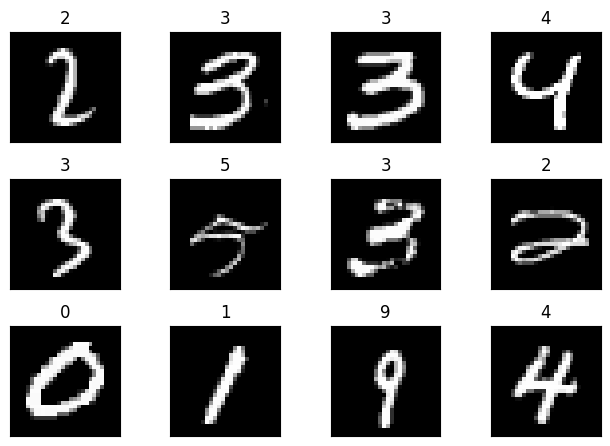

In [23]:
#Visualization


import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, bias = False) #input -28 OUtput-26 RF-3
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, bias = False)  #input -26 OUtput-24 RF-5
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2) #input -24 OUtput-12 RF-10
        self.conv3 = nn.Conv2d(32, 16, 3, bias = False) #input -12 OUtput-10 RF-12
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 32, 3, bias = False) #input -10 OUtput-8 RF-14
        self.bn4 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2) #input -8 OUtput-4 RF-24
        self.conv5 = nn.Conv2d(32, 10, 4, bias = False) # Input - 4, Output - 2, RF  - 30        
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, x):
        x = self.pool1(self.dropout(F.relu(self.bn2(self.conv2(self.dropout(F.relu(self.bn1(self.conv1(x)))))))))
        #print(x.shape)
        x = self.pool2(self.dropout(F.relu(self.bn4(self.conv4(self.dropout(F.relu(self.bn3(self.conv3(x)))))))))
        #print(x.shape)
        x = self.conv5(x)
        #print(x.shape)
        x = x.view(-1, 10)
        #print(x.shape)
        return F.log_softmax(x)

In [25]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda" if cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]           4,608
       BatchNorm2d-5           [-1, 32, 24, 24]              64
         Dropout2d-6           [-1, 32, 24, 24]               0
         MaxPool2d-7           [-1, 32, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           4,608
       BatchNorm2d-9           [-1, 16, 10, 10]              32
        Dropout2d-10           [-1, 16, 10, 10]               0
           Conv2d-11             [-1, 32, 8, 8]           4,608
      BatchNorm2d-12             [-1, 32, 8, 8]              64
    

<ipython-input-24-dbaaf1a4ad39>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [26]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [27]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 21):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]<ipython-input-24-dbaaf1a4ad39>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.04539421200752258 batch_id=937: 100%|██████████| 938/938 [01:34<00:00,  9.94it/s]



Test set: Average loss: 0.0452, Accuracy: 9847/10000 (98.5%)



loss=0.009323683567345142 batch_id=937: 100%|██████████| 938/938 [01:23<00:00, 11.17it/s]



Test set: Average loss: 0.0346, Accuracy: 9883/10000 (98.8%)



loss=0.005126274656504393 batch_id=937: 100%|██████████| 938/938 [01:22<00:00, 11.33it/s]



Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.2%)



loss=0.34274518489837646 batch_id=937: 100%|██████████| 938/938 [01:22<00:00, 11.34it/s]



Test set: Average loss: 0.0258, Accuracy: 9908/10000 (99.1%)



loss=0.017333220690488815 batch_id=937: 100%|██████████| 938/938 [01:22<00:00, 11.39it/s]



Test set: Average loss: 0.0239, Accuracy: 9917/10000 (99.2%)



loss=0.0037257878575474024 batch_id=937: 100%|██████████| 938/938 [01:22<00:00, 11.42it/s]



Test set: Average loss: 0.0228, Accuracy: 9924/10000 (99.2%)



loss=0.003854556707665324 batch_id=937: 100%|██████████| 938/938 [01:22<00:00, 11.39it/s]



Test set: Average loss: 0.0238, Accuracy: 9918/10000 (99.2%)



loss=0.005472552962601185 batch_id=937: 100%|██████████| 938/938 [01:25<00:00, 10.96it/s]



Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.3%)



loss=0.0008899482199922204 batch_id=937: 100%|██████████| 938/938 [01:23<00:00, 11.26it/s]



Test set: Average loss: 0.0202, Accuracy: 9929/10000 (99.3%)



loss=0.002842325484380126 batch_id=937: 100%|██████████| 938/938 [01:24<00:00, 11.15it/s]



Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.4%)



loss=0.015756018459796906 batch_id=937: 100%|██████████| 938/938 [01:26<00:00, 10.89it/s]



Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.3%)



loss=0.005384801421314478 batch_id=937: 100%|██████████| 938/938 [01:24<00:00, 11.13it/s]



Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.3%)



loss=0.024106251075863838 batch_id=937: 100%|██████████| 938/938 [01:23<00:00, 11.23it/s]



Test set: Average loss: 0.0186, Accuracy: 9940/10000 (99.4%)



loss=0.0033043324947357178 batch_id=937: 100%|██████████| 938/938 [01:24<00:00, 11.11it/s]



Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.4%)



loss=0.036588676273822784 batch_id=937: 100%|██████████| 938/938 [01:22<00:00, 11.37it/s]



Test set: Average loss: 0.0191, Accuracy: 9939/10000 (99.4%)



loss=0.05659446865320206 batch_id=937: 100%|██████████| 938/938 [01:22<00:00, 11.32it/s]



Test set: Average loss: 0.0202, Accuracy: 9930/10000 (99.3%)



loss=0.00036848385934717953 batch_id=937: 100%|██████████| 938/938 [01:25<00:00, 10.99it/s]



Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.4%)



loss=0.0013064825907349586 batch_id=937: 100%|██████████| 938/938 [01:23<00:00, 11.29it/s]



Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.4%)



loss=0.00204157130792737 batch_id=937: 100%|██████████| 938/938 [01:22<00:00, 11.32it/s]



Test set: Average loss: 0.0175, Accuracy: 9939/10000 (99.4%)



loss=0.0020355198066681623 batch_id=937: 100%|██████████| 938/938 [01:25<00:00, 10.97it/s]



Test set: Average loss: 0.0169, Accuracy: 9946/10000 (99.5%)

